In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
dateparse = lambda x: datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')

In [4]:
item_df = pd.read_csv("../data/raw/u.item", sep='|', encoding='latin-1',
                    names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'action', 
                           'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 
                           'film_noir', 'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western'])

user_df = pd.read_csv("../data/raw/u.user", sep='|', encoding='latin-1',
                      names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

rating_df = pd.read_csv("../data/raw/u.data", sep='\t', 
                        names=['user_id', 'movie_id', 'rating', 'timestamp'], 
                        parse_dates=['timestamp'], 
                        date_parser=dateparse)

# Exploration of the rating df

Full dataset of 100000 ratings by 943 users on 1682 items. Users and items are numbered consecutively from 1. The data is randomly ordered. This is a tab separated list of user id, item id, rating, and timestamp. The time stamps are unix seconds

In [5]:
rating_df.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


In [7]:
rating_df.isna().sum()

user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64

People often rank films 3/4 stars from 5

<AxesSubplot:>

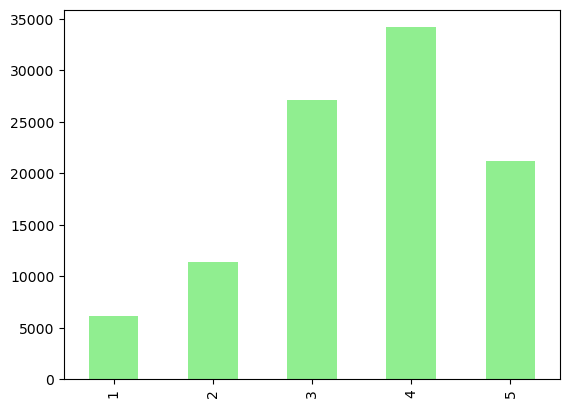

In [19]:
rating_df['rating'].value_counts().sort_index().plot.bar(color='lightgreen')

The most popular genre is drama

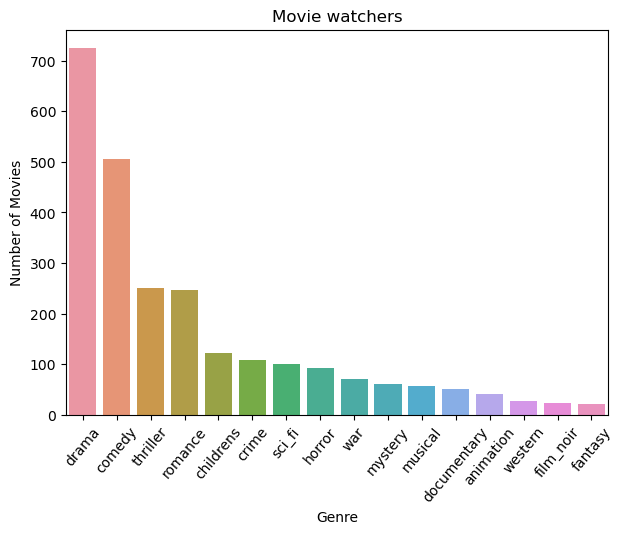

In [28]:
genre_counts = item_df.iloc[:, 6:].sum().sort_values(ascending=False)
plt.figure(figsize=(7,5))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Movie watchers')
plt.xticks(rotation=50)
plt.show()

# Exploration of the item dataframe

Information about the items (movies). This is a tab separated list of movie id, movie title, release date, video release date, IMDB URL, and genres. The last 19 fields are genres and contain binary values. Movies can be of several genres at once. The movie ids are the ones used in rating_df

In [7]:
item_df.head()

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,childrens,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
item_df.isna().sum()

movie_id                 0
movie_title              0
release_date             1
video_release_date    1682
imdb_url                 3
unknown                  0
action                   0
adventure                0
animation                0
childrens                0
comedy                   0
crime                    0
documentary              0
drama                    0
fantasy                  0
film_noir                0
horror                   0
musical                  0
mystery                  0
romance                  0
sci_fi                   0
thriller                 0
war                      0
western                  0
dtype: int64

In [10]:
item_df.drop(columns=['video_release_date', 'imdb_url'], inplace=True) # video_release_date has nan-s in each row of the df
item_df['release_date'].fillna(value=item_df['release_date'].mode()[0], inplace=True)

# Exploration of the user df 

Demographic information about the users. This is a tab separated list of user id, age, gender, occupation, zip code. The user ids are the ones used in in u.data file

In [8]:
user_df.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [9]:
user_df.isna().sum()

user_id       0
age           0
gender        0
occupation    0
zip_code      0
dtype: int64

Lets create one additional categorical feature called age_group. Min age in df is 7 and max age is 73 so we can make:
 - 5-12 - Gradeschooler
 - 13-19 - Teenager
 - 20-35 - Young
 - 35-55 - Midlife
 - above 55 - Old
 
 As we can see from bar-plot, the most part of the sample are young people in age between 35 and 55

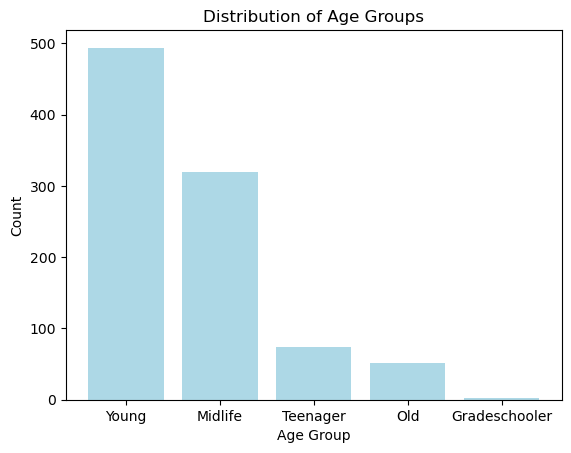

In [12]:
def categorize_age(age):
    if 5 <= age <= 12:
        return 'Gradeschooler'
    elif 13 <= age <= 19:
        return 'Teenager'
    elif 20 <= age <= 35:
        return 'Young'
    elif 35 <= age <= 55:
        return 'Midlife'
    else:
        return 'Old'

user_df['age_group'] = user_df['age'].apply(categorize_age) 

age_group_counts = user_df['age_group'].value_counts()
plt.bar(age_group_counts.index, age_group_counts.values, color = "lightblue")
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Distribution of Age Groups')
plt.show()

Females:273
Males:670


<AxesSubplot:>

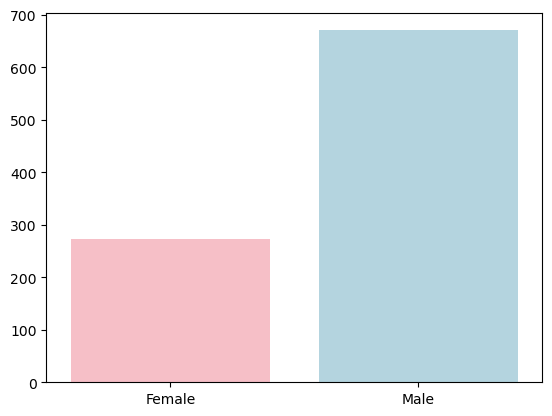

In [14]:
genders = [row["gender"] for _, row in user_df.iterrows()]

print(f"Females:{genders.count('F')}")
print(f"Males:{genders.count('M')}")

sns.barplot(x=["Female", "Male"], y=[genders.count('F'), genders.count('M')], palette=["lightpink", "lightblue"])

### Which kind of occupant watches more movies?
As we can see from plot, students in average watch movies more often than other categories 

# 😂😂😂 I guess we've discovered the first law of movie data science: the probability of movie marathons is directly proportional to the number of assignments)

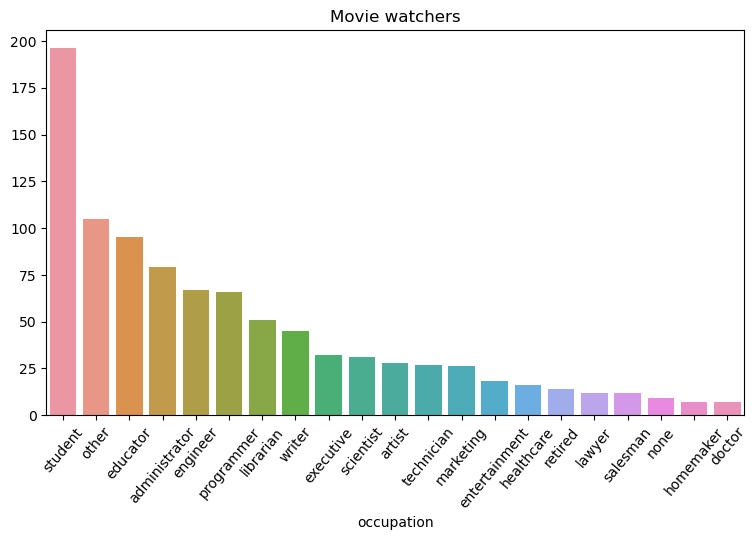

In [24]:
plt.figure(figsize=(9,5))
occupants = user_df.groupby('occupation').size().sort_values(ascending=False)
sns.barplot(x=occupants.index, y=occupants.values)
plt.title('Movie watchers')
plt.xticks(rotation=50);

## Top 10 watched movies

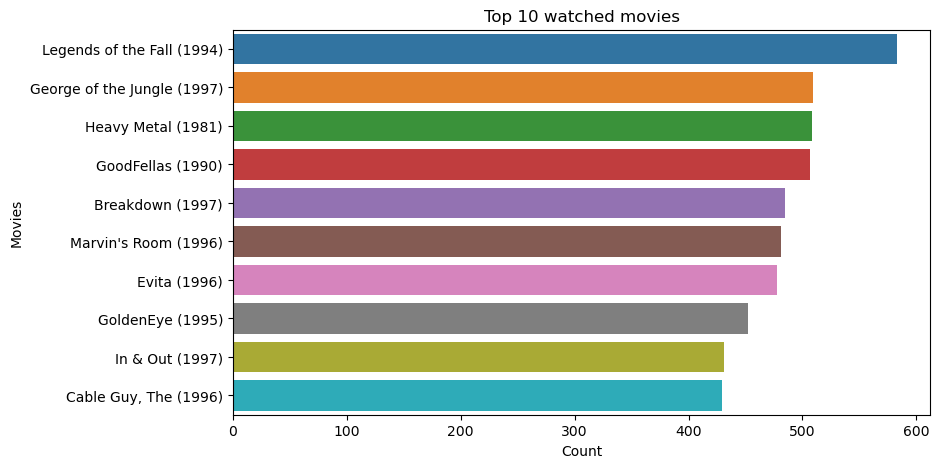

In [33]:
top_movies = rating_df.groupby('movie_id').size().sort_values(ascending=False)[:10]
top_titles = item_df.iloc[top_movies.index].movie_title

plt.figure(figsize=(9, 5))
sns.barplot(y=top_titles.values, x=top_movies.values, orient='h')
plt.title('Top 10 watched movies')
plt.ylabel('Movies')
plt.xlabel('Count')
plt.show()

# Conclusion 
- The rating value of 4 is the most frequently occurring among user ratings.
- Drama emerges as the most favored movie genre among our users based on our analysis.
- The data shows that the majority of users are male.
- A significant proportion of users fall within the age range of 20 to 30 years based on our dataset.
- "Legends of the Fall" (1994) stands out as the most frequently rated film in our dataset, based on the user ratings provided.